In [1]:
import torch
import numpy as np
from condevo.es import HADES, CHARLES
from condevo.nn import MLP
from condevo.diffusion import DDIM
from parameter_search_hades import diversity, plot_2d
import matplotlib.pyplot as plt
from copy import deepcopy

## Define the Fitness Landscape: Gaussian Double-Peaks / Dips

In [2]:
from foobench import Objective

# define the fitness function
objective = Objective(
    dim=2,
    foo="double_dip",
    maximize=True,
    foo_kwargs={"m": 1.0,   # mean (m,m), (-m-m)
                "s": 0.25,  # std
                }
)

# RASTRIGIN:
# objective = Objective(foo="rastrigin", maximize=False, limits=4, apply_limits=True, limit_val=0)

/home/bene/anaconda3/envs/condevo/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


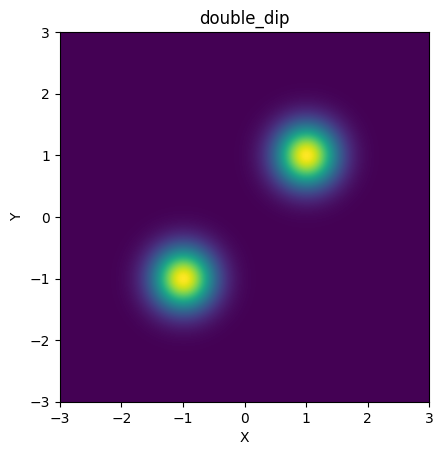

In [3]:
from foobench.plot import visualize_2D
visualize_2D(objective, parameter_range=3, n_points=1001)

## Apply HADES to learn the above Fitness Landscape

In [15]:
training_interval=3
generations=training_interval*6
popsize=512
is_genetic=True
diffuser="DDIM"
tensorboard=False

# define the neural network
num_params = objective.dim

mlp = MLP(num_params=num_params,
          num_hidden=32,
          num_layers=4,       # deeper is better
          activation='SiLU',
          layer_norm=True,    # changed to layer norm
          )

diffuser = DDIM(nn=mlp,
                num_steps=100,
                noise_level=1.0,
                alpha_schedule="linear",
                matthew_factor=1.,
                diff_range=5.0,
                log_dir="data/logs/hades" * tensorboard,
                )

# define the evolutionary strategy
solver = HADES(num_params=num_params,
                model=diffuser,
                popsize=popsize,
                sigma_init=1.0,
                is_genetic_algorithm=is_genetic,
                selection_pressure=10,
                adaptive_selection_pressure=False,
                elite_ratio=0.0, # 2 if not is_genetic else 0.4,
                mutation_rate=0.05,
                unbiased_mutation_ratio=0.1,
                crossover_ratio=0.0,
                readaptation=True,
                random_mutation_ratio=0.125,
                forget_best=True,
                diff_lr=0.003,
                diff_max_epoch=100,
                diff_batch_size=64,
                diff_weight_decay=1e-6,
                training_interval=training_interval,
                # buffer_size=0,
                )

models = []

# evolutionary loop
x, f = [], []
for g in range(generations):
    x_g = solver.ask()          # sample new parameters
    f_g = objective(x_g)        # evaluate fitness
    print(f"Generation {g} -> fitness: {f_g.max()}, diversity: {diversity(x_g)}")
    solver.tell(f_g)            # tell the solver the fitness of the parameters
    if (g + 1) % training_interval == 0:
        models.append(deepcopy(solver.model.state_dict()))

    x.append(x_g)
    f.append(f_g)


Generation 0 -> fitness: 0.9945772886276245, diversity: 1.767086148262024
Generation 1 -> fitness: 0.9095038771629333, diversity: 1.0326253175735474
Generation 2 -> fitness: 0.9925774931907654, diversity: 0.9805609583854675


Training Diffusion Model: 100%|██████████| 100/100 [00:15<00:00,  6.43epoch/s, loss=0.243]


Generation 3 -> fitness: 0.9994731545448303, diversity: 1.4904835224151611
Generation 4 -> fitness: 0.9994375109672546, diversity: 1.4953598976135254
Generation 5 -> fitness: 0.9998694658279419, diversity: 1.4742738008499146


Training Diffusion Model: 100%|██████████| 100/100 [00:21<00:00,  4.66epoch/s, loss=0.173]


Generation 6 -> fitness: 0.9998246431350708, diversity: 1.4902286529541016
Generation 7 -> fitness: 0.9999614357948303, diversity: 1.4213290214538574
Generation 8 -> fitness: 0.9998135566711426, diversity: 1.4881000518798828


Training Diffusion Model: 100%|██████████| 100/100 [00:18<00:00,  5.38epoch/s, loss=0.126]


Generation 9 -> fitness: 0.9998964071273804, diversity: 1.4516017436981201
Generation 10 -> fitness: 0.9997961521148682, diversity: 1.38236665725708
Generation 11 -> fitness: 0.9996970891952515, diversity: 1.4076311588287354


Training Diffusion Model: 100%|██████████| 100/100 [00:17<00:00,  5.79epoch/s, loss=0.121]


Generation 12 -> fitness: 0.9999924302101135, diversity: 1.4040403366088867
Generation 13 -> fitness: 0.9999135732650757, diversity: 1.3509879112243652
Generation 14 -> fitness: 0.9999210834503174, diversity: 1.313733696937561


Training Diffusion Model: 100%|██████████| 100/100 [00:20<00:00,  4.83epoch/s, loss=0.11]


Generation 15 -> fitness: 0.999695360660553, diversity: 1.4219329357147217
Generation 16 -> fitness: 0.9999626874923706, diversity: 1.3462369441986084
Generation 17 -> fitness: 0.999998927116394, diversity: 1.3343499898910522


Training Diffusion Model: 100%|██████████| 100/100 [00:20<00:00,  4.90epoch/s, loss=0.138]


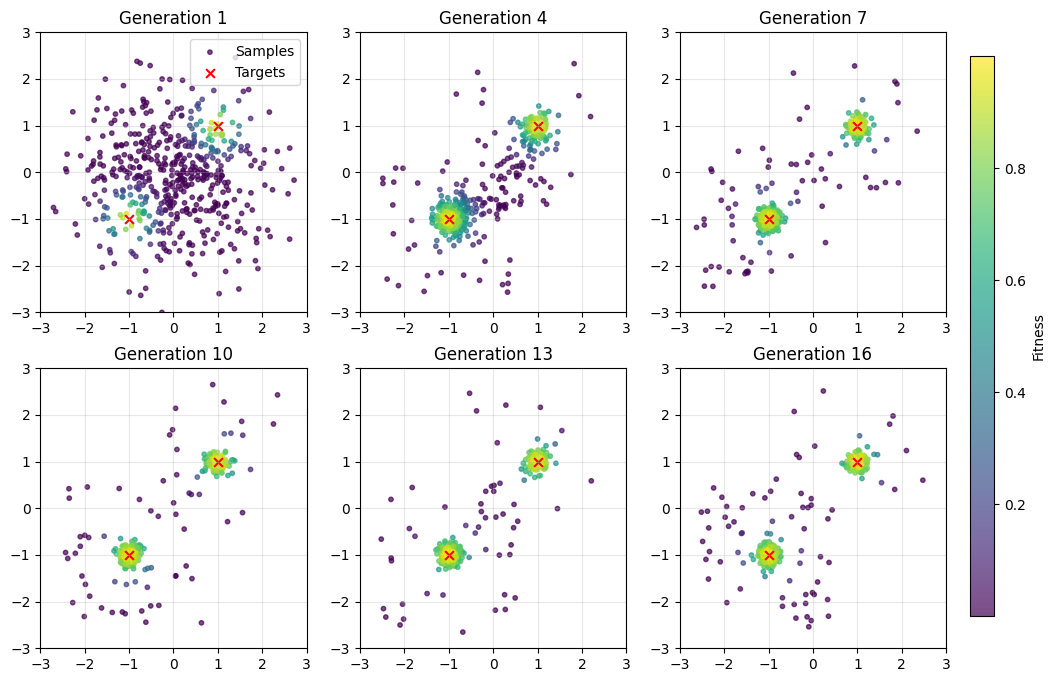

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
m = objective.foo_kwargs["m"]
targets = np.array([[-m, -m], [m, m]])

sc = None

for i in range(len(x)):
    if i % training_interval:
        continue

    ax = axes.flatten()[i // training_interval]
    sc = ax.scatter(
        x[i][:, 0], x[i][:, 1],
        c=f[i], cmap='viridis', s=10, alpha=0.7
    )
    ax.scatter(targets[:, 0], targets[:, 1],
               c='red', s=40, alpha=1, marker='x')

    ax.set_title(f'Generation {i+1}')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.grid(True, alpha=0.3)

    if i == 0:
        ax.legend(['Samples', 'Targets'], loc='upper right')

# leave space on the right for colorbar
fig.subplots_adjust(right=0.88)

# add colorbar axis [left, bottom, width, height]
cax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
fig.colorbar(sc, cax=cax, label='Fitness')

plt.show()


In [17]:
import numpy as np
import torch

def _as_condition_tensors(N: int, device, dtype, conditions):
    """Broadcast scalar-like conditions to (N,1) tensors."""
    cond_tensors = []
    for c in (conditions or ()):
        if isinstance(c, torch.Tensor):
            if c.numel() != 1:
                raise ValueError("For grid plotting, pass scalar-like conditions (numbers or 1-element tensors).")
            c = float(c.item())
        cond_tensors.append(torch.full((N, 1), float(c), device=device, dtype=dtype))
    return cond_tensors

def compute_vector_field_on_grid_xspace(
    model,
    grid_x: np.ndarray,
    grid_y: np.ndarray,
    timestep: float,
    conditions=(),
    device=None,
    dtype=torch.float32,
    field: str = "ddim_eps",  # "ddim_eps" or "rectflow_v"
):
    """
    Returns XX, YY, U, V in x-space for streamplot.

    field:
      - "ddim_eps": model output is eps(z,t); use dz_dir = -eps
      - "rectflow_v": model output is v(z,t)=dz/dt; use dz_dir = v
    """
    model.eval()
    device = device or next(model.parameters()).device

    XX, YY = np.meshgrid(grid_x, grid_y, indexing="xy")
    pts_x = np.stack([XX.ravel(), YY.ravel()], axis=1)  # (N,2)
    x_t = torch.tensor(pts_x, device=device, dtype=dtype)

    N = x_t.shape[0]
    t = torch.full((N, 1), float(timestep), device=device, dtype=dtype)
    cond_tensors = _as_condition_tensors(N, device, dtype, conditions)

    with torch.no_grad():
        dx_dir = model(x_t, t, *cond_tensors)  # z-space vector

    v = dx_dir.detach().cpu().numpy()
    U = v[:, 0].reshape(XX.shape)
    V = v[:, 1].reshape(YY.shape)
    return XX, YY, U, V


def plot_streamlines_xspace(
    model,
    grid_x,
    grid_y,
    timestep=0.25,
    conditions=(),
    device=None,
    dtype=torch.float32,
    field="ddim_eps",
    density=1.2,
    linewidth=1.0,
    arrowsize=1.0,
    color_by_speed=False,
    title="",
):
    XX, YY, U, V = compute_vector_field_on_grid_xspace(
        model=model,
        grid_x=np.asarray(grid_x),
        grid_y=np.asarray(grid_y),
        timestep=timestep,
        conditions=conditions,
        device=device,
        dtype=dtype,
        field=field,
    )

    if color_by_speed:
        speed = np.sqrt(U**2 + V**2)
        strm = plt.streamplot(
            XX, YY, U, V,
            color=speed,
            density=density,
            linewidth=linewidth,
            arrowsize=arrowsize,
        )
        plt.colorbar(strm.lines, label="|dx/dt|", pad=0.01)
    else:
        plt.streamplot(
            XX, YY, U, V,
            density=density,
            linewidth=linewidth,
            arrowsize=arrowsize,
        )

    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid(True, alpha=0.25)

def overlay_samples_fitness_xspace(x_samples, f_samples, targets=None, norm=None, s=12, alpha=0.75):
    x_np = x_samples.detach().cpu().numpy()
    f_np = f_samples.detach().cpu().numpy()

    sc = plt.scatter(
        x_np[:, 0], x_np[:, 1],
        c=f_np, cmap="viridis",
        norm=norm, s=s, alpha=alpha
    )
    if targets is not None:
        t_np = np.asarray(targets)
        plt.scatter(t_np[:, 0], t_np[:, 1], c="red", s=60, marker="x")
    return sc


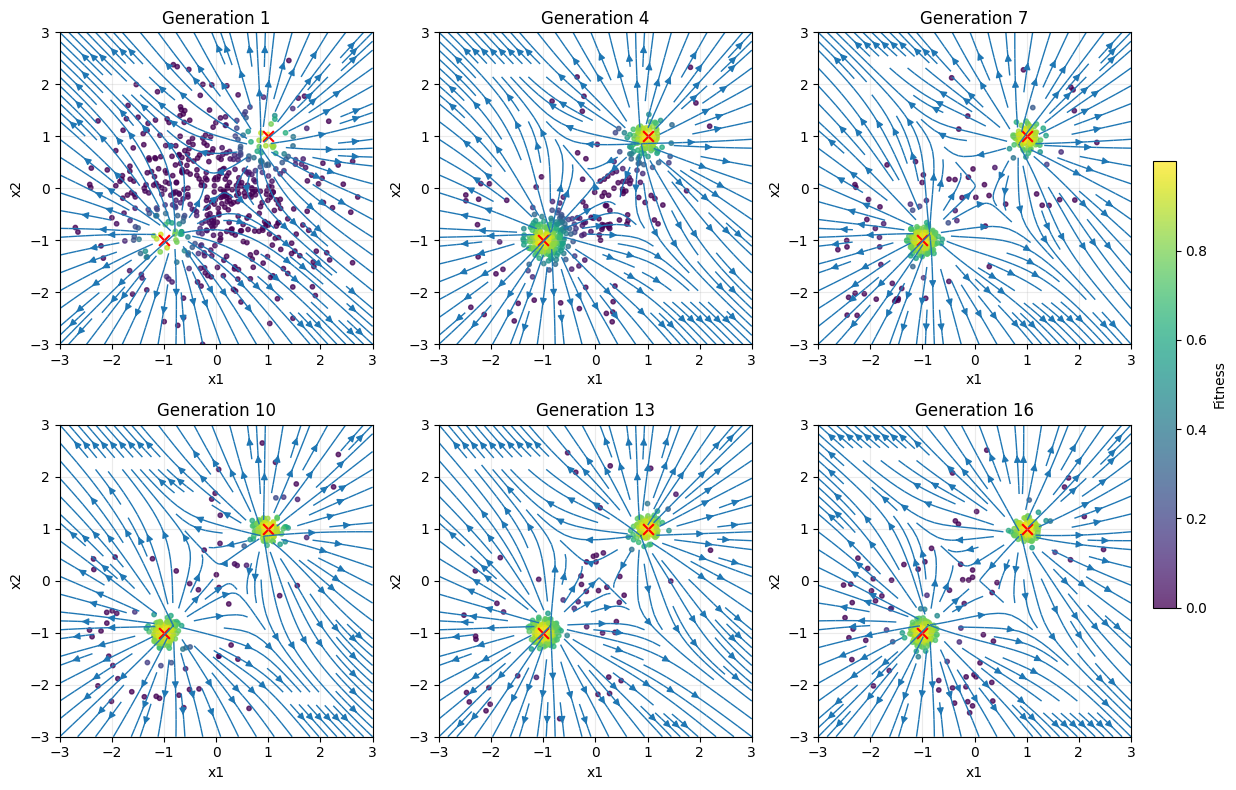

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# targets in x-space
m = objective.foo_kwargs["m"]
targets = np.array([[m, m], [-m, -m]])

# choose grid in x-space
grid_x = np.linspace(-3, 3, 80)
grid_y = np.linspace(-3, 3, 80)

# global fitness normalization so colors comparable across subplots
all_f = torch.cat([f[i * training_interval].flatten() for i in range(len(models))], dim=0).detach().cpu().numpy()
norm = mpl.colors.Normalize(vmin=float(np.min(all_f)), vmax=float(np.max(all_f)))

plt.figure(figsize=(12, 8))

sc = None
for i in range(len(models)):
    gen_idx = i * training_interval

    ax = plt.subplot(2, 3, i + 1)

    solver.model.load_state_dict(models[i])
    model = solver.model

    # pick field type:
    # - for DDIM/VPred: "ddim_eps"
    # - for RectFlow: "rectflow_v"
    field = "ddim_eps"  # change if needed

    plot_streamlines_xspace(
        model,
        grid_x, grid_y,
        timestep=0.25,
        conditions=(),                 # scalar-like conditions if any
        device=solver.device,
        dtype=torch.float32,
        field=field,
        density=1.2,
        linewidth=1.0,
        arrowsize=1.0,
        color_by_speed=False,
        title=f"Generation {gen_idx + 1}",
    )

    sc = overlay_samples_fitness_xspace(
        x_samples=x[gen_idx],
        f_samples=f[gen_idx],
        targets=targets,
        norm=norm,
        s=10,
        alpha=0.75
    )

    plt.xlim(grid_x.min(), grid_x.max())
    plt.ylim(grid_y.min(), grid_y.max())

plt.tight_layout()

# one shared fitness colorbar
cbar = plt.colorbar(sc, ax=plt.gcf().axes, fraction=0.02, pad=0.02)
cbar.set_label("Fitness")

plt.show()


## Quadrant-Wise Conditioning

### Define the Condition
For this, we use the `from condevo.es.guidance import Condition` baseclass

In [19]:
from condevo.es.guidance import FitnessCondition, Condition  # load conditions

- Samples falling into quadranr #1 are colored red, and have conditional value $1$
- Samples falling into quadranr #3 are colored blue, and have conditional value $-1$
- Samples falling into quadrants #2 or #4 are colored green, and have conditional value $0$

Note: no targets fall into quadrants #2 and #4

In [20]:
from torch import Tensor, tensor, float32, ones

class QCondition(Condition):
    def __init__(self, target=1, ):
        Condition.__init__(self)
        self.target = target

    def evaluate(self, charles_instance, x, *args, **kwargs):
        dim = np.shape(x)[-1]
        g0 = x > 0
        rc = np.zeros(len(x))              # per default, everything is labeled "0", but this only remains for the 2nd and 4th quadrant (see below)

        rc[g0[:,0] & g0[:,1]] = 1.         # evaluated condition for x & y > 0 -> first quadrant is labeled "1"
        rc[(~g0[:,0]) & (~g0[:,1])] = -1.  # same for x & y < 0 -> third quadrant is labeled "-1"
        if isinstance(x, Tensor):
            return tensor(rc, device=x.device, dtype=float32)
        return rc

    def sample(self, charles_instance, num_samples):
        # sample target quadrant, with label defined in "evaluate"
        return ones(num_samples, dtype=float32) * self.target

    def to_dict(self):
        return {"target": self.target, **Condition.to_dict(self)}


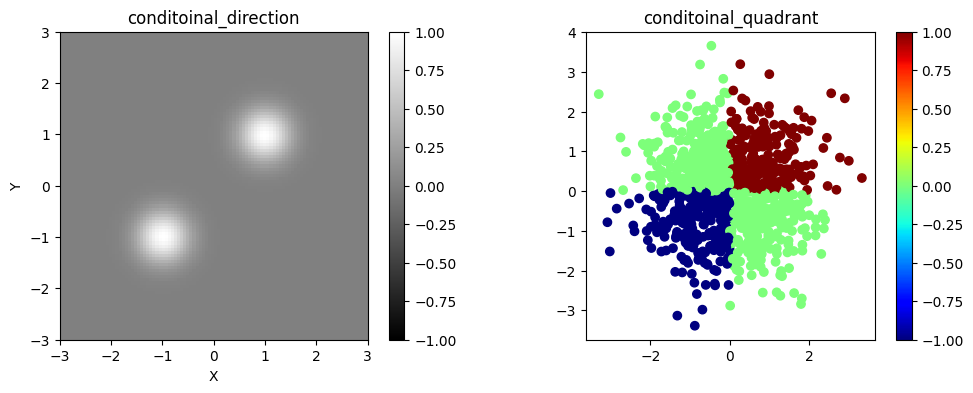

In [21]:
import matplotlib.pyplot as plt
from foobench.plot import visualize_2D

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
im1 = visualize_2D(objective, logscale=False, parameter_range=3, ax=ax1, cmap="binary_r", vmin=-1, vmax=1)

x = np.random.randn(1000, 2)
c_qud = QCondition().evaluate(None, x)

im2 = ax2.scatter(*x.T, c=c_qud, cmap="jet")
plt.colorbar(im1, ax=ax1)
plt.colorbar(im2, ax=ax2)
ax1.set_aspect("equal")
ax1.set_title("conditoinal_direction")
ax2.set_aspect("equal")
ax2.set_title("conditoinal_quadrant");

### Conditional Evolution / CHARLES

In [23]:
training_interval=3
generations=training_interval*6
popsize=512
sample_uniform=False
is_genetic=False
diffuser="DDIM"
tensorboard=False

# define the neural network
num_params = objective.dim

In [24]:
condition_models = [
    {"Q": -1, "models": [], "x": [], "f": []},
    {"Q": 0, "models": [], "x": [], "f": []},
    {"Q": 1, "models": [], "x": [], "f": []},
]

for cm in condition_models:
    Q = cm["Q"]
    models = cm["models"]
    x = cm["x"]
    f = cm["f"]

    conditions = [QCondition(target=Q),]  # list/tuple of conditions

    mlp = MLP(num_params=num_params,
              num_hidden=32,
              num_layers=4,
              activation='SiLU',
              layer_norm=True,
              num_conditions=len(conditions),   # <- add channels per condition
              )

    diffuser = DDIM(nn=mlp,
                    num_steps=100,
                    noise_level=1,
                    alpha_schedule="cosine_nichol",
                    matthew_factor=1.,
                    diff_range=5.0,
                    # predict_eps_t=True,
                    log_dir="data/logs/hades" * tensorboard,
                    )

    # define the evolutionary strategy
    charles = CHARLES(num_params=num_params,
                     model=diffuser,
                     popsize=popsize,
                     sigma_init=0.1,
                     is_genetic_algorithm=is_genetic,
                     selection_pressure=10,
                     adaptive_selection_pressure=False,
                     elite_ratio=0.0, # 2 if not is_genetic else 0.4,
                     mutation_rate=0.05,
                     unbiased_mutation_ratio=0.1,
                     crossover_ratio=0.0,
                     readaptation=True,
                     random_mutation_ratio=0.125,
                     forget_best=True,
                     diff_lr=0.003,
                     diff_max_epoch=100,
                     diff_batch_size=64,
                     diff_weight_decay=1e-6,
                     # buffer_size=0,  # don't restrict buffer size
                     training_interval=training_interval,
                      # CONDITIONS, YOU MIGHT ADD FitnessCondition to the tuple, or change the target to 0 (quadrant 2 & 4) or -1 (quadrant 3)
                     conditions=conditions  # <- add conditions here: go for the first quadrant only
                     )

    # evolutionary loop
    for g in range(generations):
        x_g = charles.ask()          # sample new parameters
        f_g = objective(x_g)        # evaluate fitness
        print(f"Generation {g} -> fitness: {f_g.max()}, diversity: {diversity(x_g)}")
        charles.tell(f_g)            # tell the charles the fitness of the parameters
        if (g + 1) % training_interval == 0:
            models.append(deepcopy(charles.model.state_dict()))

        x.append(x_g)
        f.append(f_g)


Generation 0 -> fitness: 0.015001831576228142, diversity: 0.17808149755001068
Generation 1 -> fitness: 0.8300087451934814, diversity: 0.8012433052062988
Generation 2 -> fitness: 0.776237964630127, diversity: 0.7898833155632019


Training Diffusion Model: 100%|██████████| 100/100 [00:15<00:00,  6.61epoch/s, loss=0.00337]


Generation 3 -> fitness: 0.9369316697120667, diversity: 0.5958849787712097
Generation 4 -> fitness: 0.9761279225349426, diversity: 0.5915387868881226
Generation 5 -> fitness: 0.9730574488639832, diversity: 0.6170138120651245


Training Diffusion Model: 100%|██████████| 100/100 [00:21<00:00,  4.68epoch/s, loss=0.00306]


Generation 6 -> fitness: 0.9975929260253906, diversity: 0.5213441252708435
Generation 7 -> fitness: 0.9992674589157104, diversity: 0.540270209312439
Generation 8 -> fitness: 0.9996316432952881, diversity: 0.5331801176071167


Training Diffusion Model: 100%|██████████| 100/100 [00:22<00:00,  4.47epoch/s, loss=0.00813]


Generation 9 -> fitness: 0.9998673796653748, diversity: 0.24810178577899933
Generation 10 -> fitness: 0.9998407363891602, diversity: 0.21902000904083252
Generation 11 -> fitness: 0.9998798370361328, diversity: 0.19255194067955017


Training Diffusion Model: 100%|██████████| 100/100 [00:23<00:00,  4.35epoch/s, loss=0.0163]


Generation 12 -> fitness: 0.9999470710754395, diversity: 0.10601243376731873
Generation 13 -> fitness: 0.9999891519546509, diversity: 0.10470935702323914
Generation 14 -> fitness: 0.9999615550041199, diversity: 0.10300644487142563


Training Diffusion Model: 100%|██████████| 100/100 [00:22<00:00,  4.46epoch/s, loss=0.0111]


Generation 15 -> fitness: 0.9999876022338867, diversity: 0.06550441682338715
Generation 16 -> fitness: 0.9999853372573853, diversity: 0.0662548765540123
Generation 17 -> fitness: 0.999970018863678, diversity: 0.06508689373731613


Training Diffusion Model: 100%|██████████| 100/100 [00:22<00:00,  4.39epoch/s, loss=0.0111]


Generation 0 -> fitness: 0.0077101094648242, diversity: 0.1789325773715973
Generation 1 -> fitness: 0.9893409609794617, diversity: 0.7059586644172668
Generation 2 -> fitness: 0.9983821511268616, diversity: 0.7772826552391052


Training Diffusion Model: 100%|██████████| 100/100 [00:16<00:00,  6.08epoch/s, loss=0.00215]


Generation 3 -> fitness: 0.21193906664848328, diversity: 0.6500566005706787
Generation 4 -> fitness: 0.10674913972616196, diversity: 0.6673414707183838
Generation 5 -> fitness: 0.12881255149841309, diversity: 0.6531441807746887


Training Diffusion Model: 100%|██████████| 100/100 [00:22<00:00,  4.49epoch/s, loss=0.00244]


Generation 6 -> fitness: 0.3258194327354431, diversity: 0.510755181312561
Generation 7 -> fitness: 0.08384674787521362, diversity: 0.472343385219574
Generation 8 -> fitness: 0.20311430096626282, diversity: 0.5060089826583862


Training Diffusion Model: 100%|██████████| 100/100 [00:22<00:00,  4.35epoch/s, loss=0.00297]


Generation 9 -> fitness: 0.5631826519966125, diversity: 0.3678956627845764
Generation 10 -> fitness: 0.560504138469696, diversity: 0.40917766094207764
Generation 11 -> fitness: 0.4560132920742035, diversity: 0.38445770740509033


Training Diffusion Model: 100%|██████████| 100/100 [00:23<00:00,  4.24epoch/s, loss=0.00412]


Generation 12 -> fitness: 0.36457279324531555, diversity: 0.323649525642395
Generation 13 -> fitness: 0.9358945488929749, diversity: 0.30614203214645386
Generation 14 -> fitness: 0.36994999647140503, diversity: 0.3232988119125366


Training Diffusion Model: 100%|██████████| 100/100 [00:24<00:00,  4.01epoch/s, loss=0.00311]


Generation 15 -> fitness: 0.7172871828079224, diversity: 0.531904935836792
Generation 16 -> fitness: 0.4365868866443634, diversity: 0.5361140370368958
Generation 17 -> fitness: 0.31192097067832947, diversity: 0.5467634797096252


Training Diffusion Model: 100%|██████████| 100/100 [00:36<00:00,  2.73epoch/s, loss=0.0033]


Generation 0 -> fitness: 0.006709573324769735, diversity: 0.166944682598114
Generation 1 -> fitness: 0.9830901622772217, diversity: 0.889358639717102
Generation 2 -> fitness: 0.9957065582275391, diversity: 0.9379916787147522


Training Diffusion Model: 100%|██████████| 100/100 [00:16<00:00,  5.96epoch/s, loss=0.00505]


Generation 3 -> fitness: 0.9882665872573853, diversity: 0.8033114671707153
Generation 4 -> fitness: 0.9862462282180786, diversity: 0.8008763790130615
Generation 5 -> fitness: 0.9971368312835693, diversity: 0.8339694142341614


Training Diffusion Model: 100%|██████████| 100/100 [00:22<00:00,  4.43epoch/s, loss=0.00383]


Generation 6 -> fitness: 0.9992667436599731, diversity: 0.356810599565506
Generation 7 -> fitness: 0.9997451901435852, diversity: 0.44607308506965637
Generation 8 -> fitness: 0.9997060298919678, diversity: 0.4383813142776489


Training Diffusion Model: 100%|██████████| 100/100 [00:20<00:00,  4.86epoch/s, loss=0.0149]


Generation 9 -> fitness: 0.9997905492782593, diversity: 0.29337796568870544
Generation 10 -> fitness: 0.9999845027923584, diversity: 0.2381896674633026
Generation 11 -> fitness: 0.9999528527259827, diversity: 0.19241571426391602


Training Diffusion Model: 100%|██████████| 100/100 [00:21<00:00,  4.56epoch/s, loss=0.021]


Generation 12 -> fitness: 0.9999814629554749, diversity: 0.10452920943498611
Generation 13 -> fitness: 0.9999783635139465, diversity: 0.11336681246757507
Generation 14 -> fitness: 0.9999752044677734, diversity: 0.09717348217964172


Training Diffusion Model: 100%|██████████| 100/100 [00:16<00:00,  6.07epoch/s, loss=0.0139]


Generation 15 -> fitness: 0.9999906420707703, diversity: 0.05647428706288338
Generation 16 -> fitness: 0.9999945163726807, diversity: 0.05438309162855148
Generation 17 -> fitness: 0.9999797344207764, diversity: 0.05256013199687004


Training Diffusion Model: 100%|██████████| 100/100 [00:20<00:00,  4.83epoch/s, loss=0.00872]


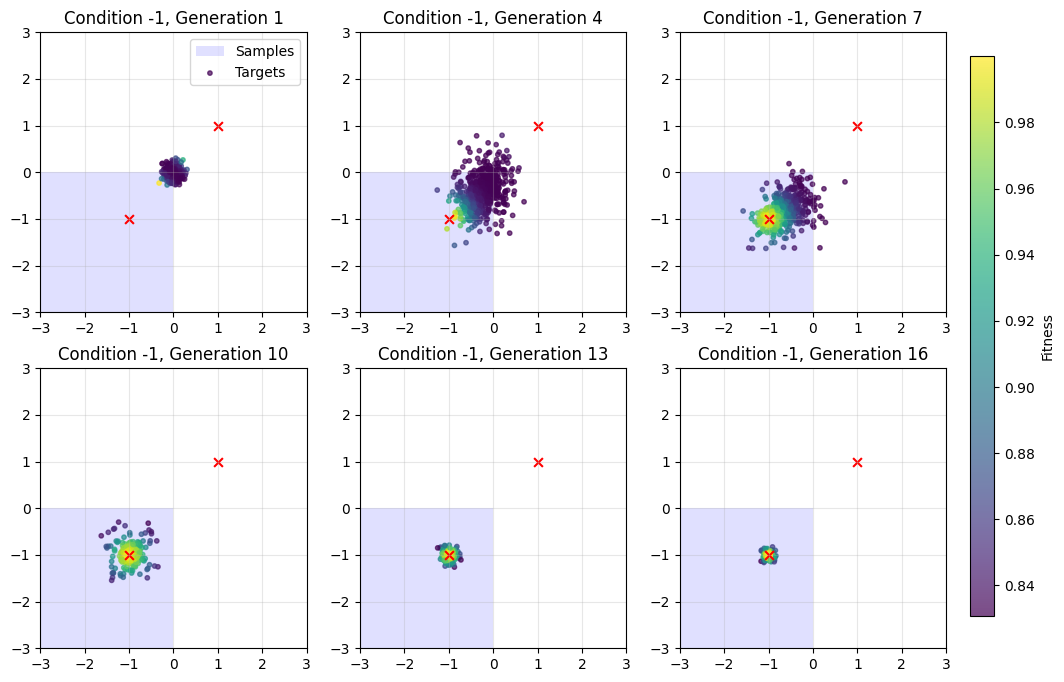

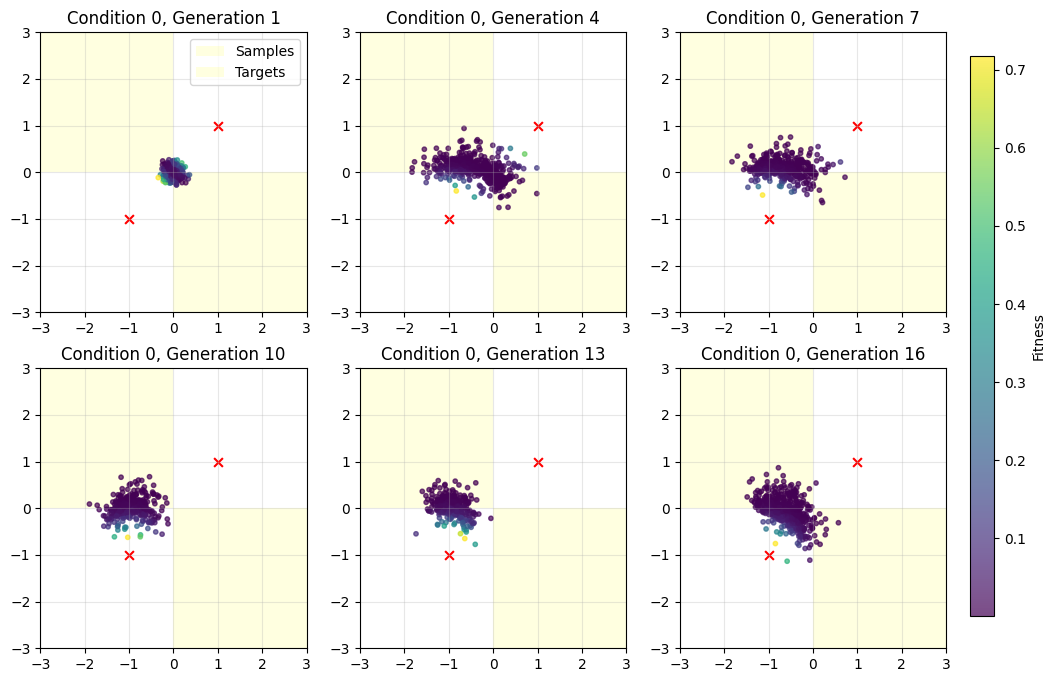

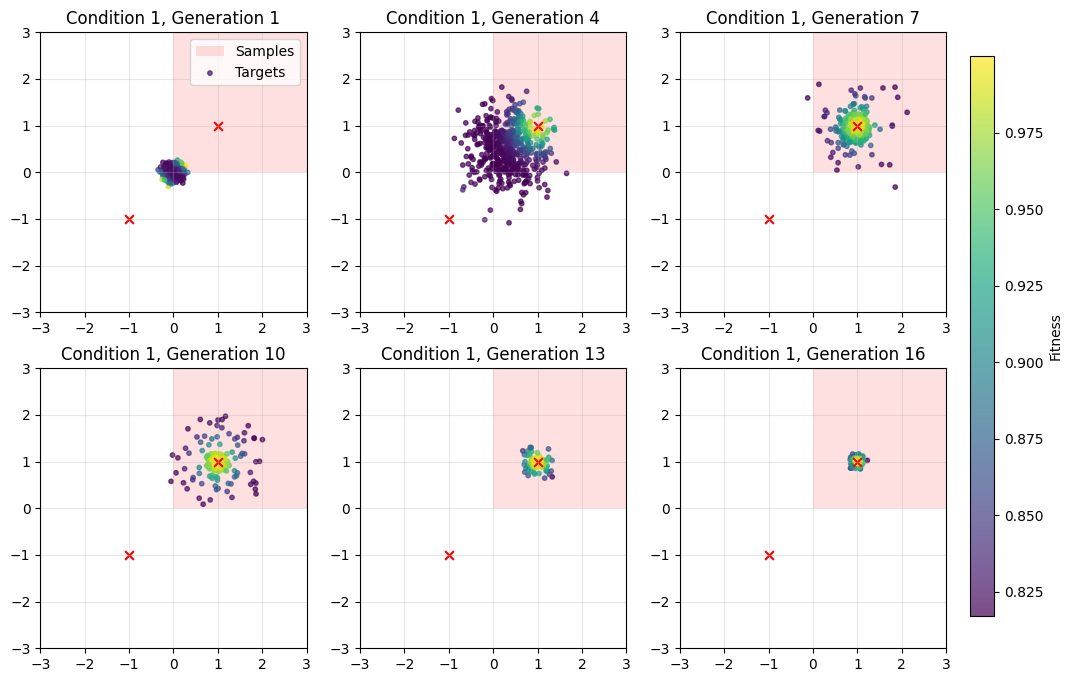

In [29]:
# matplotlib animation (2d array across generations) with colored fitness
m = objective.foo_kwargs["m"]
targets = np.array([[m, m], [-m, -m]])

import matplotlib.patches as patches

def add_quadrant_boxes(ax, Q, lim=3):
    """
    Add colored rectangles indicating target quadrants.
    """
    alpha = 0.12  # subtle background

    if Q == 1:
        # First quadrant (red)
        ax.add_patch(patches.Rectangle((0, 0), lim, lim, facecolor="red", alpha=alpha, edgecolor="none"))

    elif Q == 0:
        # Second quadrant (yellow)
        ax.add_patch(patches.Rectangle((-lim, 0), lim, lim, facecolor="yellow", alpha=alpha,edgecolor="none"))
        # Fourth quadrant (yellow)
        ax.add_patch(patches.Rectangle((0, -lim), lim, lim, facecolor="yellow", alpha=alpha, edgecolor="none"))

    elif Q == -1:
        # Third quadrant (blue)
        ax.add_patch(patches.Rectangle((-lim, -lim), lim, lim, facecolor="blue", alpha=alpha, edgecolor="none"))


for cm in condition_models:
    Q, x, f = cm["Q"], cm["x"], cm["f"]

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    sc = None
    for i in range(len(x)):
        if i % training_interval:
            continue

        ax = axes.flatten()[i // training_interval]
        add_quadrant_boxes(ax, Q, lim=3)
        sc = ax.scatter(
            x[i][:, 0], x[i][:, 1],
            c=f[i], cmap='viridis', s=10, alpha=0.7
        )
        ax.scatter(targets[:, 0], targets[:, 1],
                   c='red', s=40, alpha=1, marker='x')

        ax.set_title(f'Condition {Q}, Generation {i+1}')
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.grid(True, alpha=0.3)

        if i == 0:
            ax.legend(['Samples', 'Targets'], loc='upper right')

    # leave space on the right for colorbar
    fig.subplots_adjust(right=0.88)

    # add colorbar axis [left, bottom, width, height]
    cax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
    fig.colorbar(sc, cax=cax, label='Fitness')

    plt.show()


In [38]:
def add_streamlines(ax, model, xlim, ylim, condition, timestep=0.25, n_grid=30):
    """
    Overlays streamlines of the model's vector field in x-space on the given axis.
    - Assumes 2D input (x,y).
    - Uses model.scaler to convert z-space field -> x-space field when available.
    - For DDIM-like models we use v = -eps direction; for RectFlow we use v = v_pred.
      (If you know which you're using, you can simplify with a flag.)
    """
    # grid in x-space
    xs = np.linspace(xlim[0], xlim[1], n_grid)
    ys = np.linspace(ylim[0], ylim[1], n_grid)
    X, Y = np.meshgrid(xs, ys)
    grid_x = np.stack([X.ravel(), Y.ravel()], axis=1)

    device = model.device
    dtype = next(model.parameters()).dtype

    x_t = torch.tensor(grid_x, device=device, dtype=dtype)
    t = torch.full((x_t.shape[0], 1), float(timestep), device=device, dtype=dtype)
    conditions = (torch.tensor([[Q]]*len(x_t), device=device, dtype=dtype),)


    model.eval()
    with torch.no_grad():

        v_x = -model(x_t, t, *conditions)  # z-space field

    v = v_x.detach().cpu().numpy()
    U = v[:, 0].reshape(Y.shape)
    V = v[:, 1].reshape(Y.shape)

    #ax.streamplot(X, Y, U, V, density=1.0, linewidth=0.8, arrowsize=0.8, color="k", alpha=0.35)
    sp = ax.streamplot(
        X, Y, U, V,
        density=1.0,
        linewidth=0.8,
        arrowsize=0.8,
        color="k",
    )
    sp.lines.set_alpha(0.35)
    sp.arrows.set_alpha(0.35)


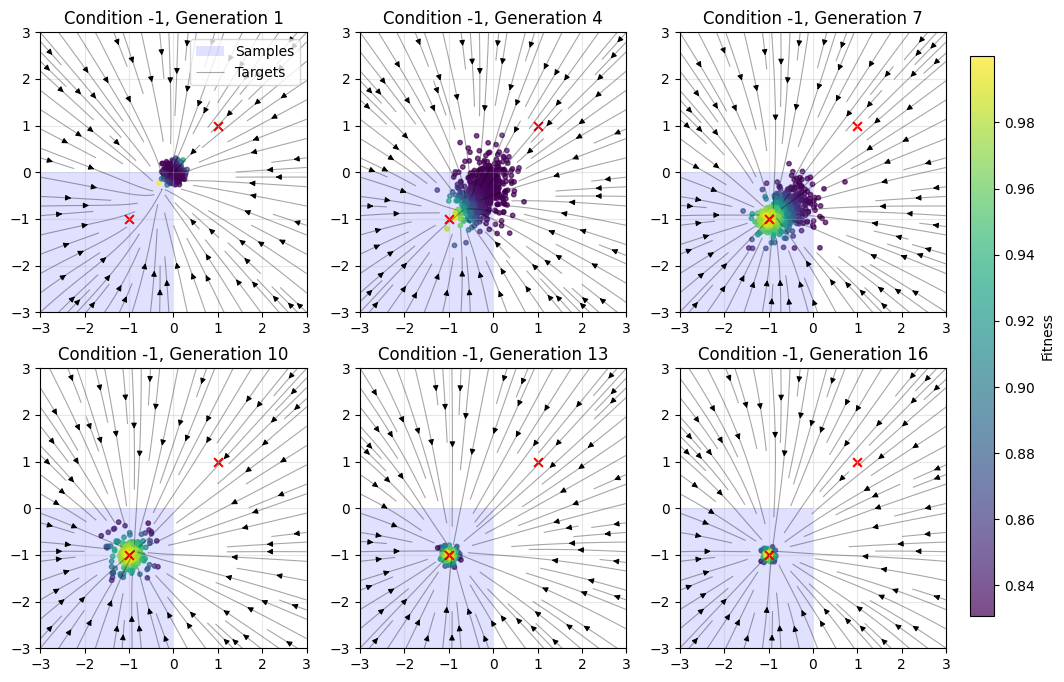

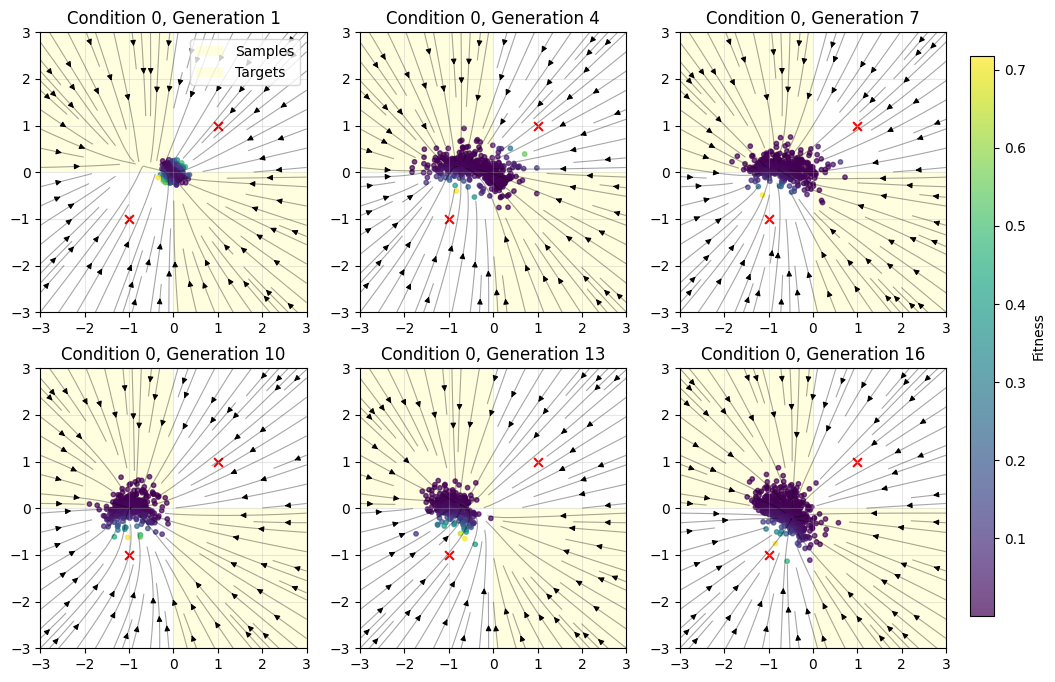

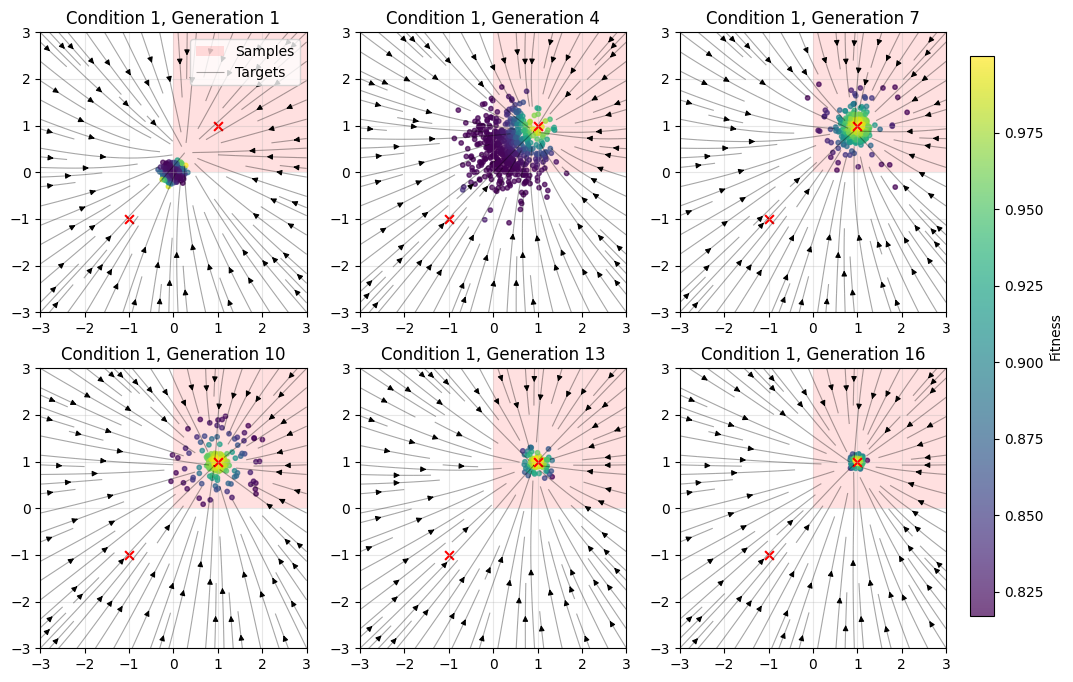

In [41]:
xlim = (-3, 3)
ylim = (-3, 3)

for cm in condition_models:
    Q, x, f = cm["Q"], cm["x"], cm["f"]

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))

    sc = None
    for i in range(len(x)):
        if i % training_interval:
            continue

        ax = axes.flatten()[i // training_interval]

        # --- LOAD THE MODEL FOR THIS GENERATION (you must adapt this line) ---
        # Example patterns:
        charles.model.load_state_dict(cm["models"][i // training_interval])
        model = charles.model  # <-- replace with your per-generation model

        # --- add streamlines FIRST (so points sit on top) ---
        add_quadrant_boxes(ax, Q, lim=3)
        add_streamlines(ax, model, xlim=xlim, ylim=ylim, timestep=0.25, n_grid=35, condition=Q)

        sc = ax.scatter(x[i][:, 0], x[i][:, 1], c=f[i], cmap='viridis', s=10, alpha=0.7)
        ax.scatter(targets[:, 0], targets[:, 1], c='red', s=40, alpha=1, marker='x')

        ax.set_title(f'Condition {Q}, Generation {i+1}')
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
        ax.grid(True, alpha=0.3)

        if i == 0:
            ax.legend(['Samples', 'Targets'], loc='upper right')

    fig.subplots_adjust(right=0.88)
    cax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
    fig.colorbar(sc, cax=cax, label='Fitness')

    plt.show()
